In [1]:
# cloning the github repository of yolov5 and installing the requirements
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
!pip install albumentations

Cloning into 'yolov5'...
remote: Enumerating objects: 15637, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 15637 (delta 123), reused 171 (delta 100), pack-reused 15393
Receiving objects: 100% (15637/15637), 14.58 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (10652/10652), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# downloading the coco dataset using the yolov5 script get_coco.sh
!bash data/scripts/get_coco.sh --train --val --test --segments

######################################################################## 100.0%
######################################################################## 100.0%
######################################################################## 100.0%
######################################################################## 100.0%


In [3]:
from torchvision.datasets import CocoDetection
import torch
import albumentations as A
from torchvision import models


# CustomDataset class is inherited from the CocoDetection class
class CustomDataset(CocoDetection):
    # The init function has been modified according to our needs 
    def __init__(self,
                 root,
                 annFile,
                 transform=None,
                 target_transform=None) -> None:
        super().__init__(root, annFile, transform, target_transform)
       
    # The getitem function has been modified according to our needs (to return the image and the target)

    def __getitem__(self, index: int):
        img, target = super().__getitem__(index)
        return img, target

# getting the pretrained model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# declaring the transformations
transform = A.Compose([
    A.CLAHE(), # contrast limiting adaptive histogram equalization
    A.RandomRotate90(), # rotate the image by 0, 90, 180, or 270 degrees
    A.Transpose(),  # transpose the input by swapping rows and columns.
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75), # random scaling and rotating with a 75% probability
    A.Blur(blur_limit=21, always_apply=True), # blur the input image using a random-sized kernel
    A.OpticalDistortion(), # apply optical distortion to the input image
    A.GridDistortion(), # apply grid distortion to the input image
    A.HueSaturationValue(), # randomly change hue, saturation and value of the input image
    A.RandomBrightnessContrast(p=0.3, always_apply=True), # randomly change brightness and contrast of the input image
])

# creating the dataset
coco_dataset = CustomDataset(root='/content/coco', annFile='/content/datasets/coco/annotations/instances_val2017.json')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-5-2 Python-3.10.11 torch-2.0.0+cu118 CPU



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


100%|██████████| 14.1M/14.1M [00:00<00:00, 76.1MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


Loading the annotations from the json given file

In [4]:
import json
# loading annotations
annotations = json.load(open('/content/datasets/coco/annotations/instances_val2017.json'))

In [5]:
name_classes = []


# Creating a dictionary that will hold the images names and their annotations
final_structure = dict()
for img in annotations['images']:
    final_structure[str(img['id'])] = dict()
    final_structure[str(img['id'])]['image'] = img 
for annot in annotations['annotations']:
    final_structure[str(annot['image_id'])]['annotation'] = annot 
# Creating a dictionary that will hold the classes and their numbers
categories_associations = dict()
for ex in annotations['categories']:
  # creating a list of the classes names
    name_classes.append(ex['name'])
    categories_associations[ex['id']] = ex['name']

# TESTING
# Creating a dictionary that will hold the test images names and their annotations
test_id_filename = dict()
cnt = 0
for img in annotations['images']:
  test_id_filename[img['file_name']] = {"id": img['id']}
  for annot in annotations['annotations']:
    if annot['image_id'] == img['id']:
      try:
        test_id_filename[img['file_name']]['annotation'].append(annot['category_id'])
      except:
        test_id_filename[img['file_name']]['annotation'] = [annot['category_id']]
      cnt += 1
#print("CNT FINAL : ", cnt)
# END TESTING

# Initiating the classes that are going to hold the images names, the classes and their numbers
image_names = list()
classes = list()
classes_number = list()
# Looping over the dictionary to fill the lists
cnt = 0
for x in final_structure.keys():
    image = final_structure[x]['image']
    try:
      # filling the lists
      annot = final_structure[x]['annotation']
      image_names.append(image['file_name'])
      classes.append(categories_associations[annot['category_id']])
      classes_number.append(annot['category_id'])
    except KeyError:
      classes.append("nothing")
      classes_number.append(-1)        

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory

In [6]:

# Creating a dictionary that will hold the images names and their annotations
for key in test_id_filename.keys():
  test_classes = list()
  try:
    for annot in test_id_filename[key]['annotation']:
      # filling the test_classes list
      test_classes.append(categories_associations[annot])
  except:
    # filling the test_classes list
    test_classes.append("nothing")
    # filling the test_id_filename dictionary
    test_id_filename[key]['annotation'] = [-1]
    test_id_filename[key]['classes'] = test_classes

{'000000397133.jpg': {'id': 397133, 'annotation': [44, 67, 1, 49, 51, 51, 79, 1, 47, 47, 51, 51, 56, 50, 56, 56, 79, 57, 81]}, '000000037777.jpg': {'id': 37777, 'annotation': [64, 62, 62, 67, 82, 52, 79, 81, 55, 55, 55, 55, 62, 55]}, '000000252219.jpg': {'id': 252219, 'annotation': [1, 1, 1, 28, 31, 47, 10]}, '000000087038.jpg': {'id': 87038, 'annotation': [2, 1, 1, 1, 1, 1, 1, 2, 41, 1, 1, 1, 1, 1, 1, 1, 1]}, '000000174482.jpg': {'id': 174482, 'annotation': [2, 3, 3, 10, 10, 3, 3, 3, 8, 8, 8, 10]}, '000000403385.jpg': {'id': 403385, 'annotation': [70, 81]}, '000000006818.jpg': {'id': 6818, 'annotation': [70]}, '000000480985.jpg': {'id': 480985, 'annotation': [4, 4, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1]}, '000000458054.jpg': {'id': 458054, 'annotation': [70, 70, 70, 70, 70, 70, 70, 70, 70, 70]}, '000000331352.jpg': {'id': 331352, 'annotation': [70, 81]}, '000000296649.jpg': {'id': 296649, 'annotation': [3, 3, 3, 4, 4, 1, 1, 1, 1, 1, 1, 2, 8, 16, 16, 1, 1, 1, 1, 4, 16, 16, 1, 1, 3, 1]}, '000

In [7]:
#print(test_id_filename)

{'000000397133.jpg': {'id': 397133, 'annotation': [44, 67, 1, 49, 51, 51, 79, 1, 47, 47, 51, 51, 56, 50, 56, 56, 79, 57, 81], 'classes': ['bottle', 'dining table', 'person', 'knife', 'bowl', 'bowl', 'oven', 'person', 'cup', 'cup', 'bowl', 'bowl', 'broccoli', 'spoon', 'broccoli', 'broccoli', 'oven', 'carrot', 'sink']}, '000000037777.jpg': {'id': 37777, 'annotation': [64, 62, 62, 67, 82, 52, 79, 81, 55, 55, 55, 55, 62, 55], 'classes': ['potted plant', 'chair', 'chair', 'dining table', 'refrigerator', 'banana', 'oven', 'sink', 'orange', 'orange', 'orange', 'orange', 'chair', 'orange']}, '000000252219.jpg': {'id': 252219, 'annotation': [1, 1, 1, 28, 31, 47, 10], 'classes': ['person', 'person', 'person', 'umbrella', 'handbag', 'cup', 'traffic light']}, '000000087038.jpg': {'id': 87038, 'annotation': [2, 1, 1, 1, 1, 1, 1, 2, 41, 1, 1, 1, 1, 1, 1, 1, 1], 'classes': ['bicycle', 'person', 'person', 'person', 'person', 'person', 'person', 'bicycle', 'skateboard', 'person', 'person', 'person', 'p


NAME :  000000528862
shape ?  torch.Size([3, 500, 375])
Original class :  ['giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe']
results :  ['giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe']
item giraffe

NAME :  000000177861
shape ?  torch.Size([3, 480, 640])
Original class :  ['umbrella', 'umbrella', 'car', 'car', 'handbag', 'bicycle', 'person', 'person', 'car', 'umbrella', 'umbrella', 'chair', 'dining table', 'person', 'backpack', 'backpack', 'umbrella', 'umbrella', 'person']
results :  ['car', 'person', 'person', 'person', 'umbrella', 'chair', 'umbrella', 'car', 'person', 'chair', 'dog', 'car', 'car', 'car', 'umbrella']
item backpack
item umbrella
item handbag
item car
item person
item dog
item dining table
item chair
item bicycle

NAME :  000000393014
shape ?  torch.Size([3, 640, 480])
Original class :  ['sandwich', 'sandwich', 'hot dog', 'hot dog']
results :  ['sandwich', 'sandwich', 'hot dog']
item hot dog
item sandwich

NAME :  0000000107

<ipython-input-15-5ea65f1801f5>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))


Original class :  ['cow', 'cow', 'cow']
results :  ['cow', 'sheep', 'cow', 'cow']
item sheep
item cow

NAME :  000000039956
shape ?  torch.Size([3, 640, 427])
Original class :  ['bed', 'chair']
results :  ['bed', 'chair', 'chair', 'cup', 'backpack', 'book']
item backpack
item book
item chair
item bed
item cup

NAME :  000000340175
shape ?  torch.Size([3, 640, 394])
Original class :  ['chair', 'chair', 'couch', 'dining table', 'bench', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'apple', 'apple', 'apple', 'chair', 'chair', 'chair', 'potted plant', 'book', 'vase', 'book', 'book', 'vase', 'chair', 'book']
results :  ['couch', 'chair', 'potted plant', 'bench', 'dining table', 'chair', 'chair', 'chair']
item bench
item potted plant
item apple
item book
item dining table
item chair
item vase
item couch

NAME :  000000321333
shape ?  torch.Size([3, 640, 397])
Original class :  ['teddy bear', 'person', 'person']
results :  ['person', 'teddy bear', 'person', 

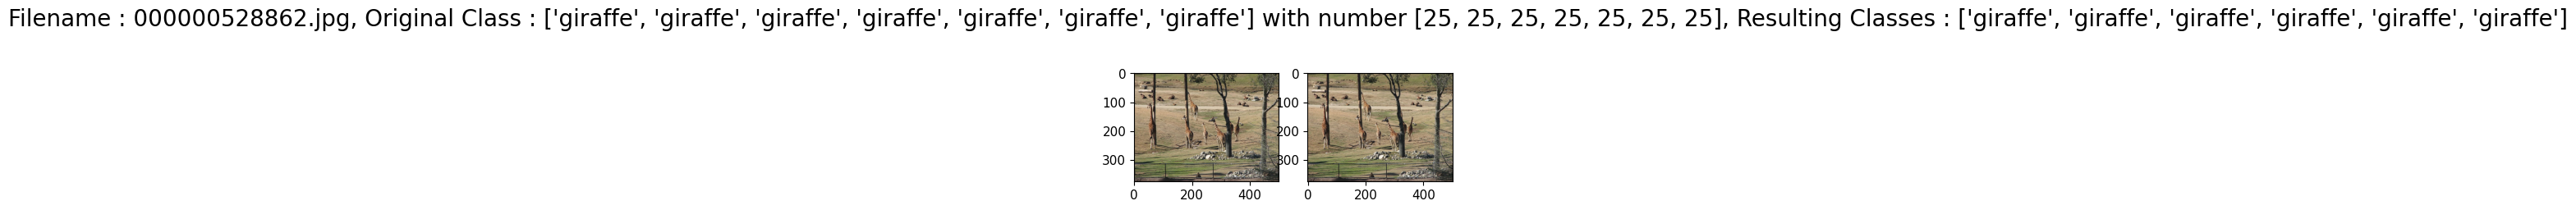

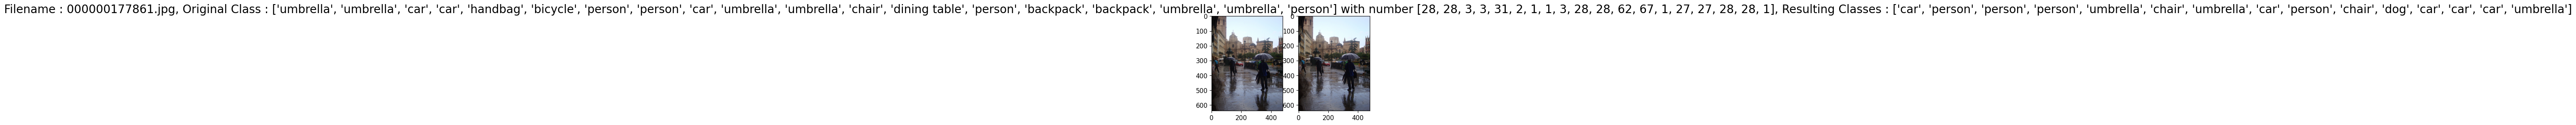

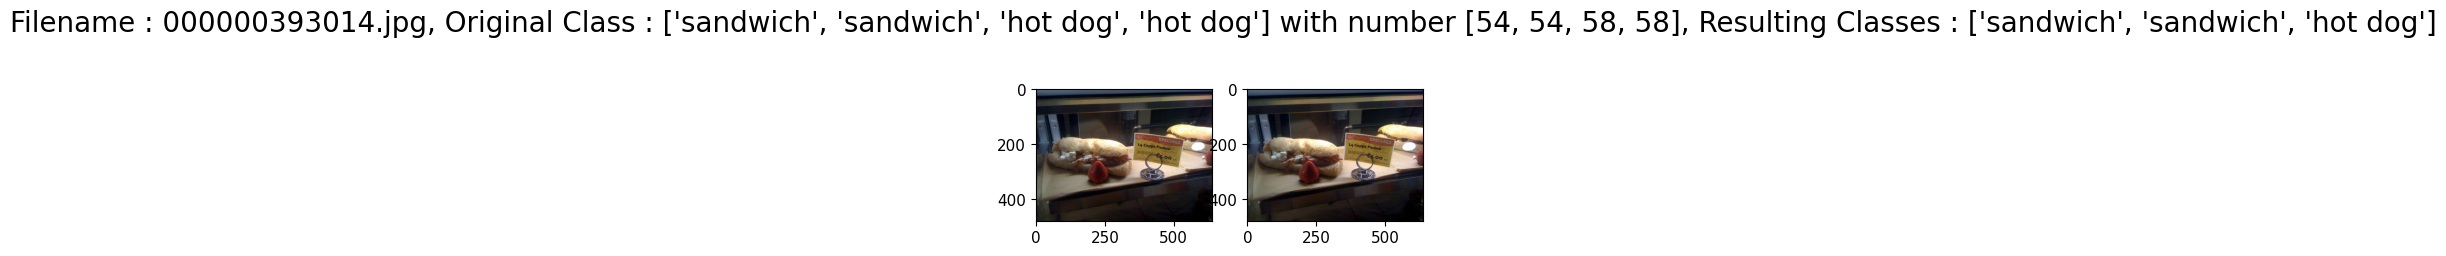

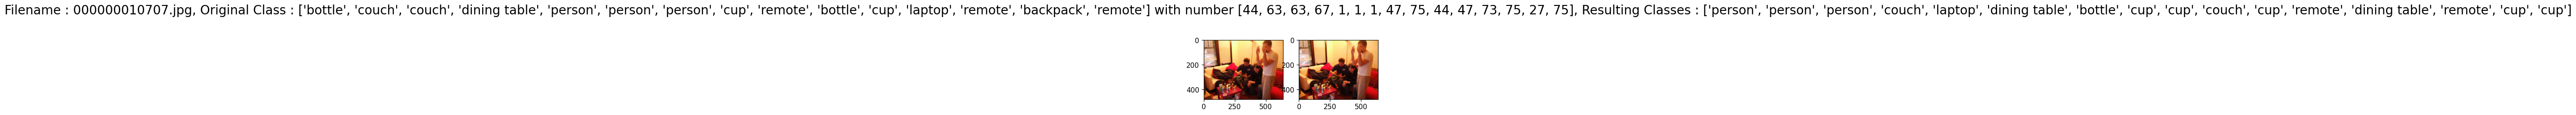

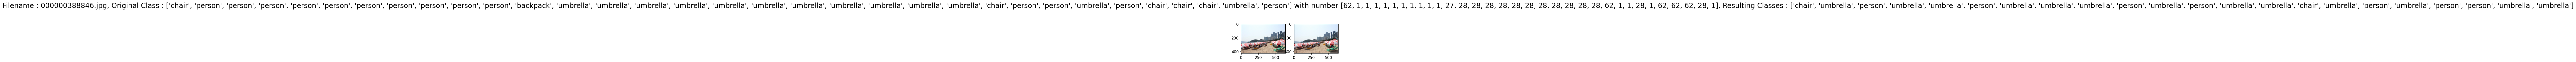

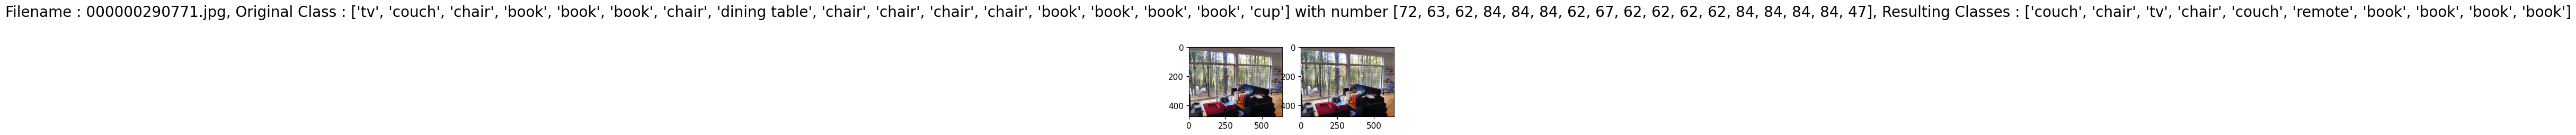

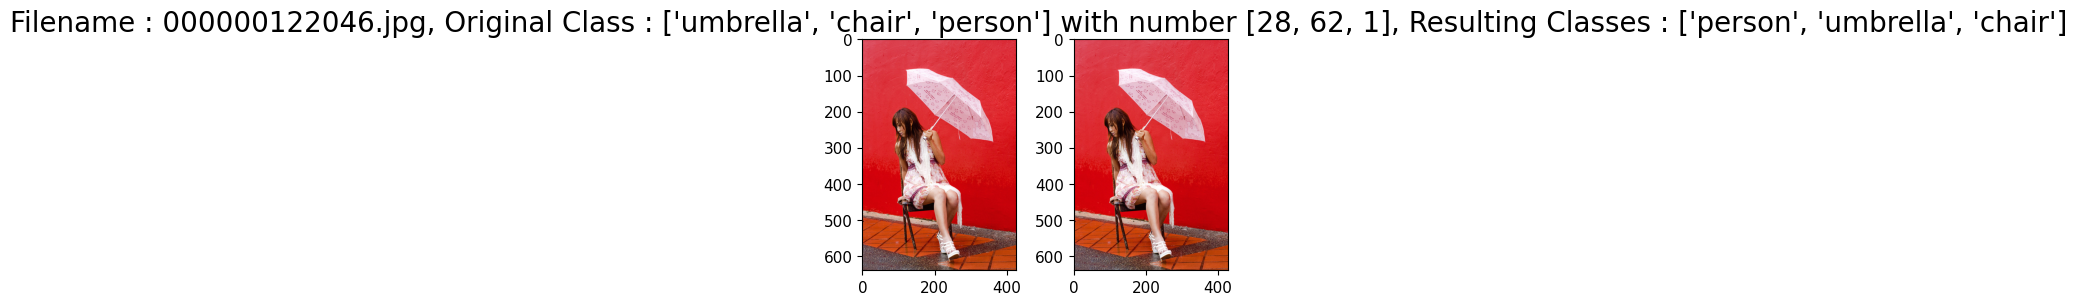

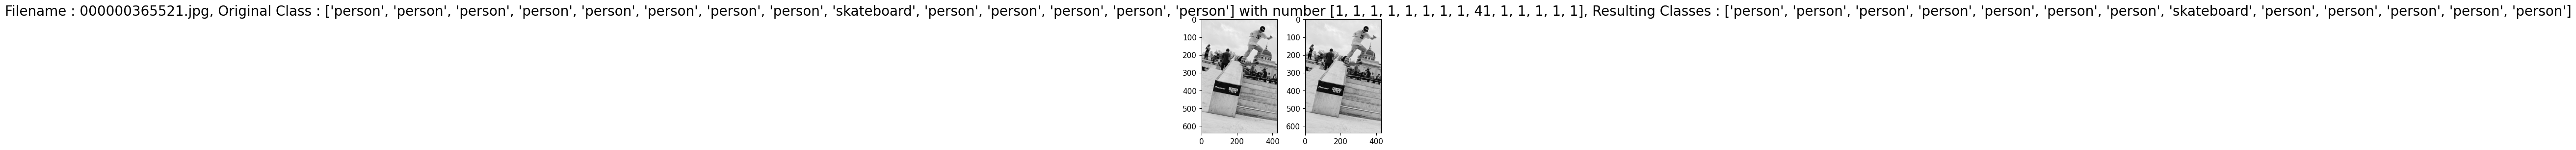

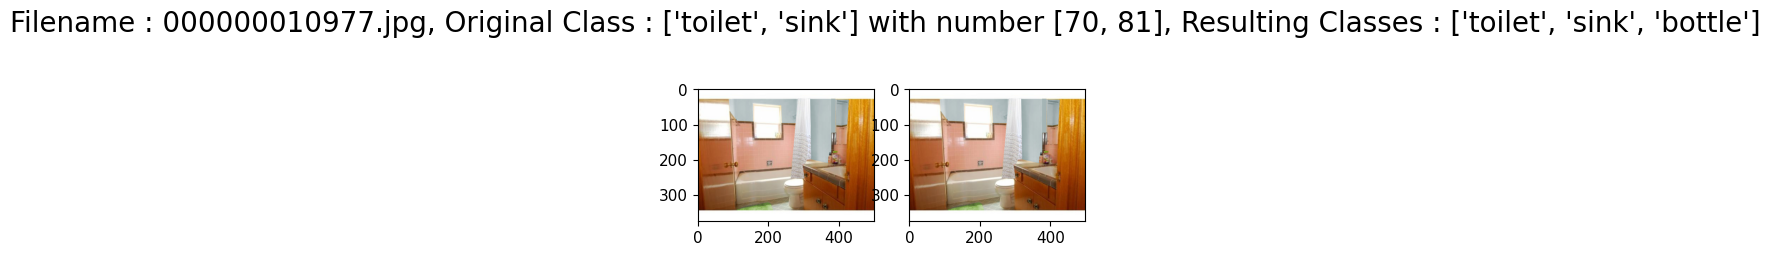

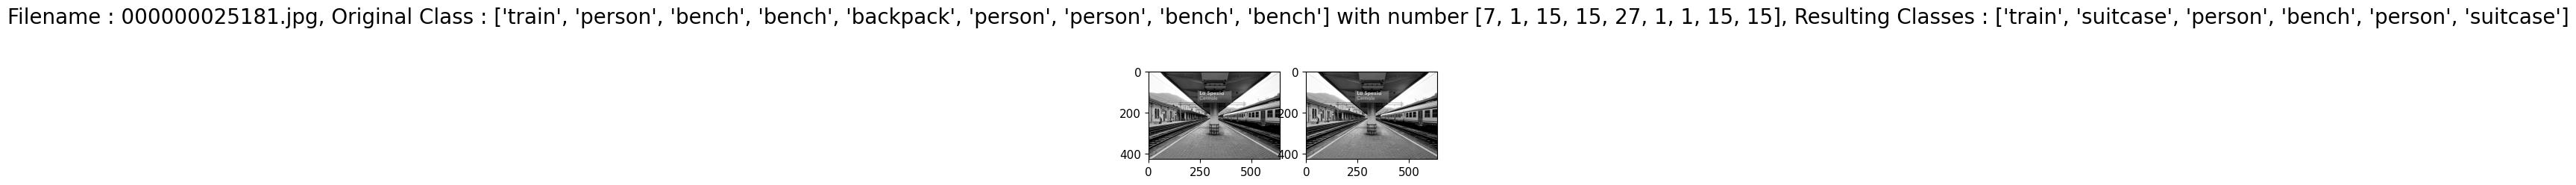

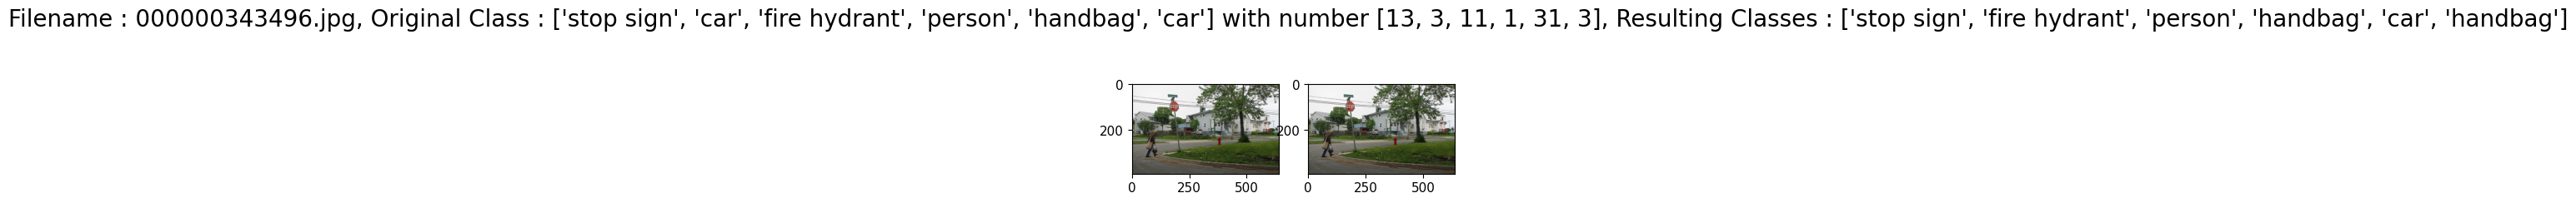

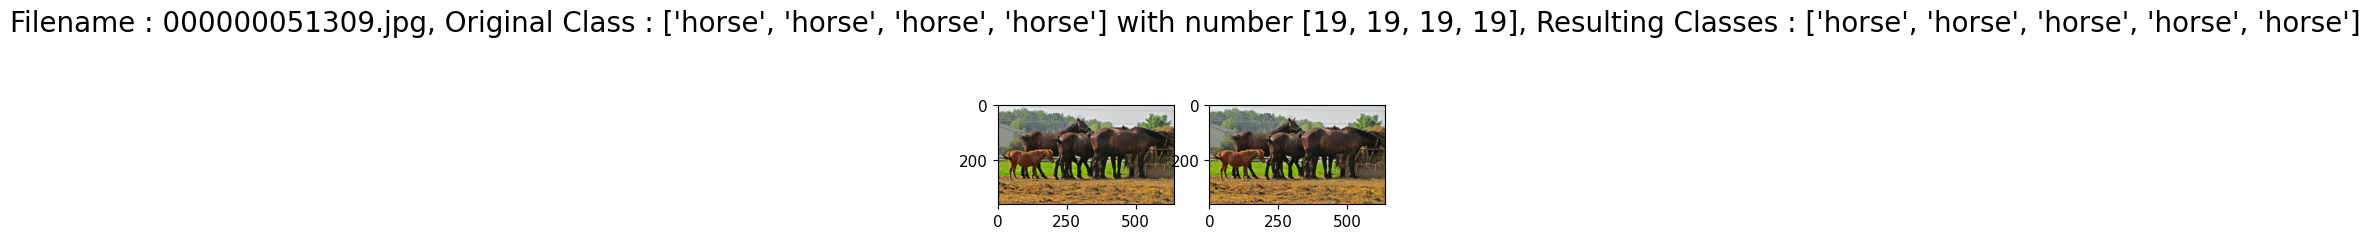

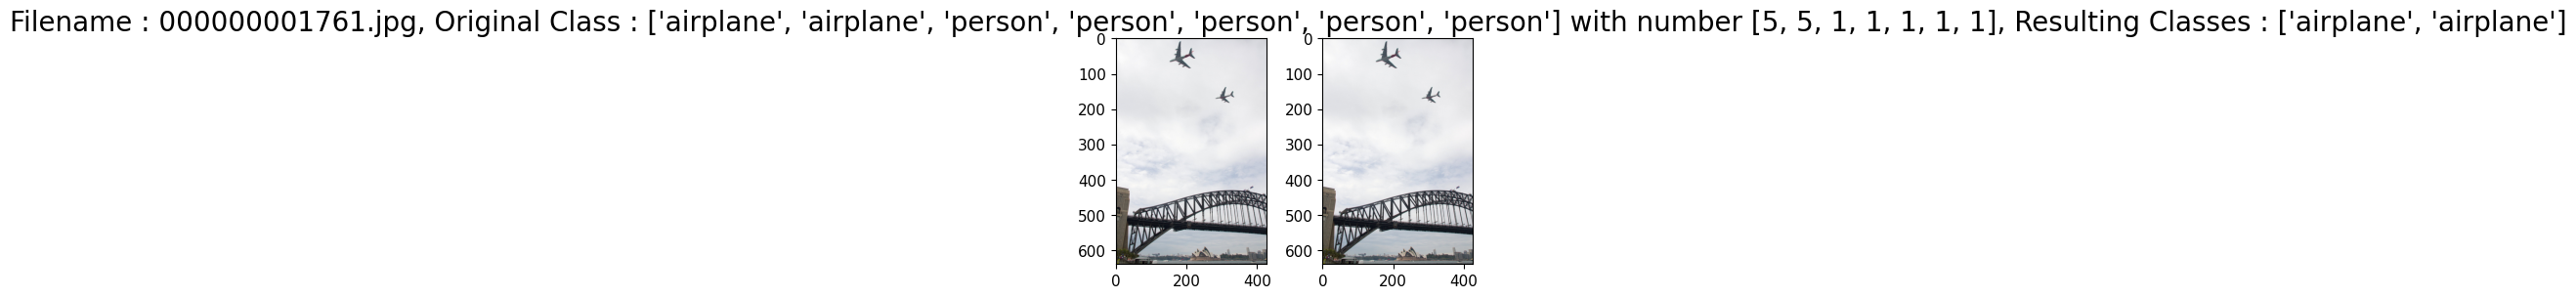

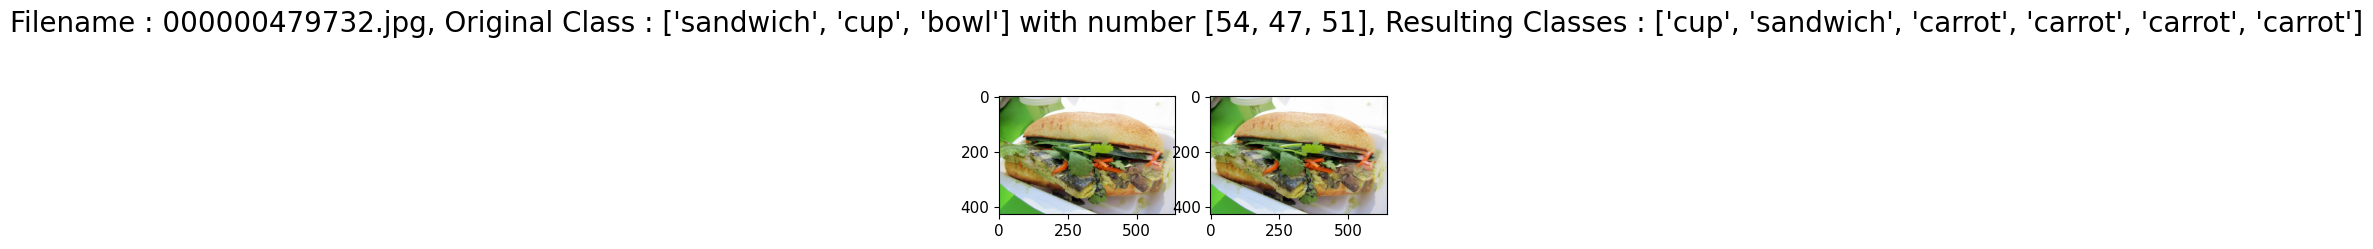

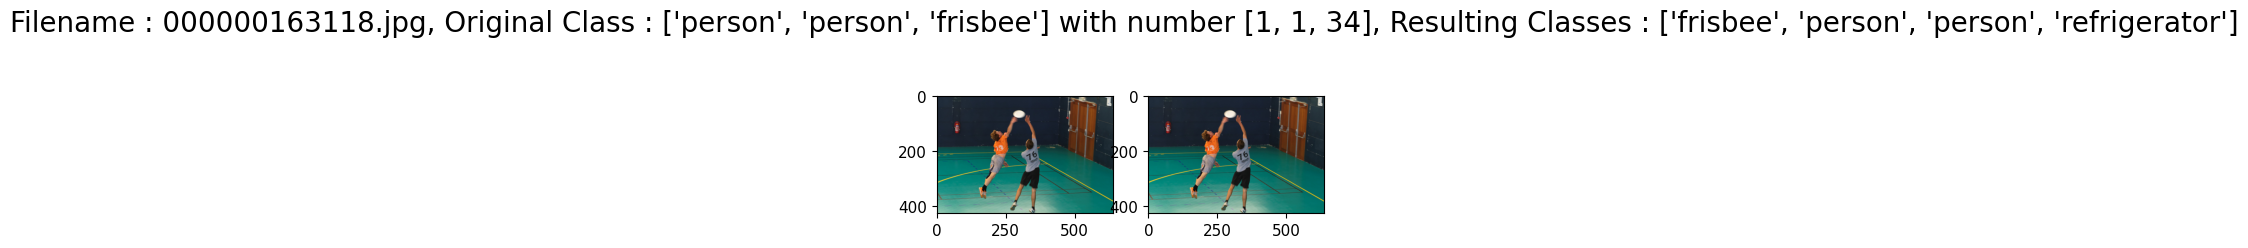

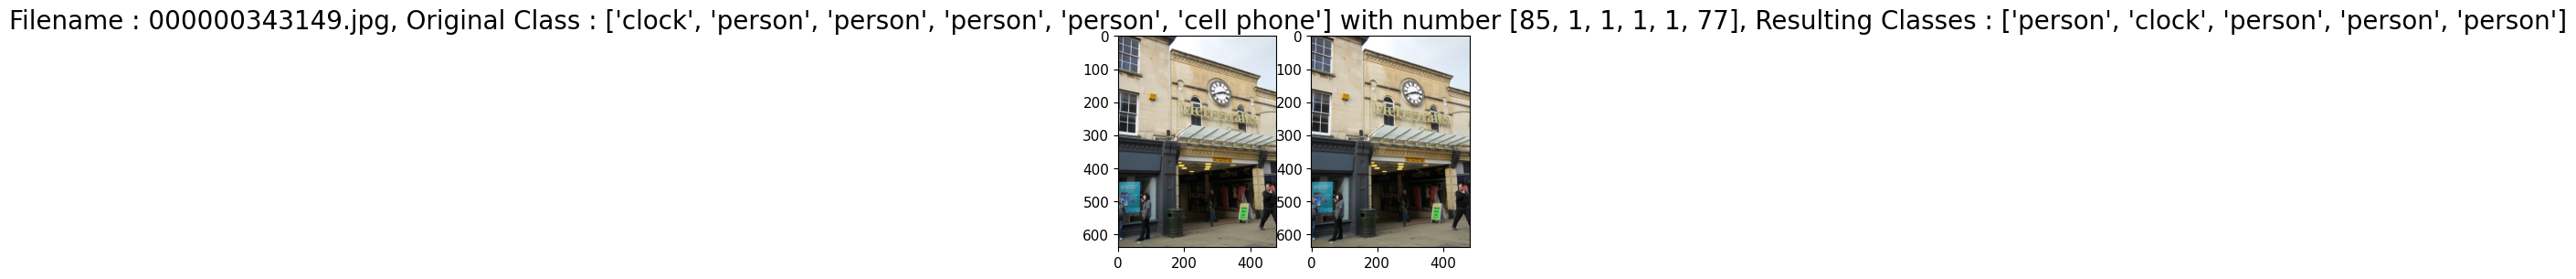

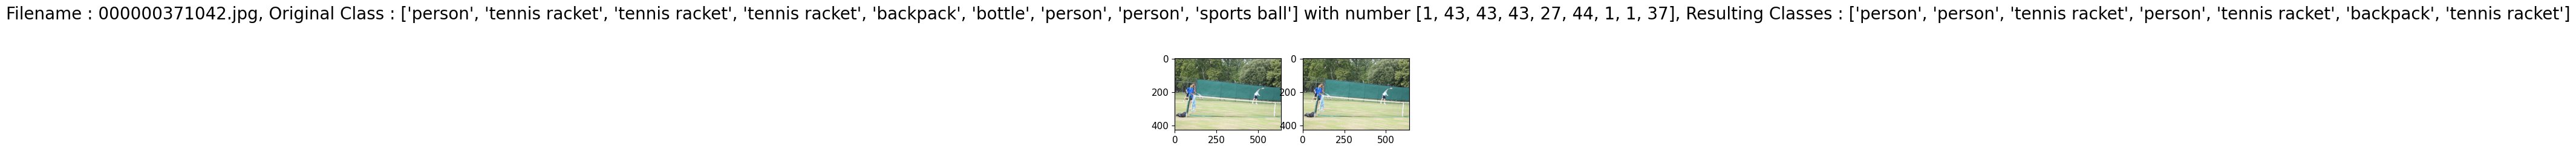

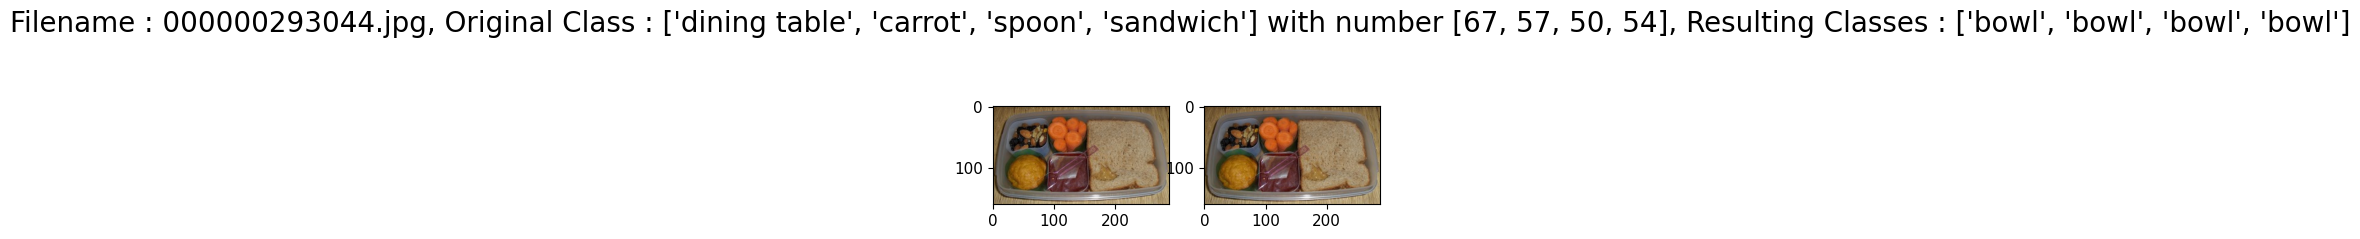

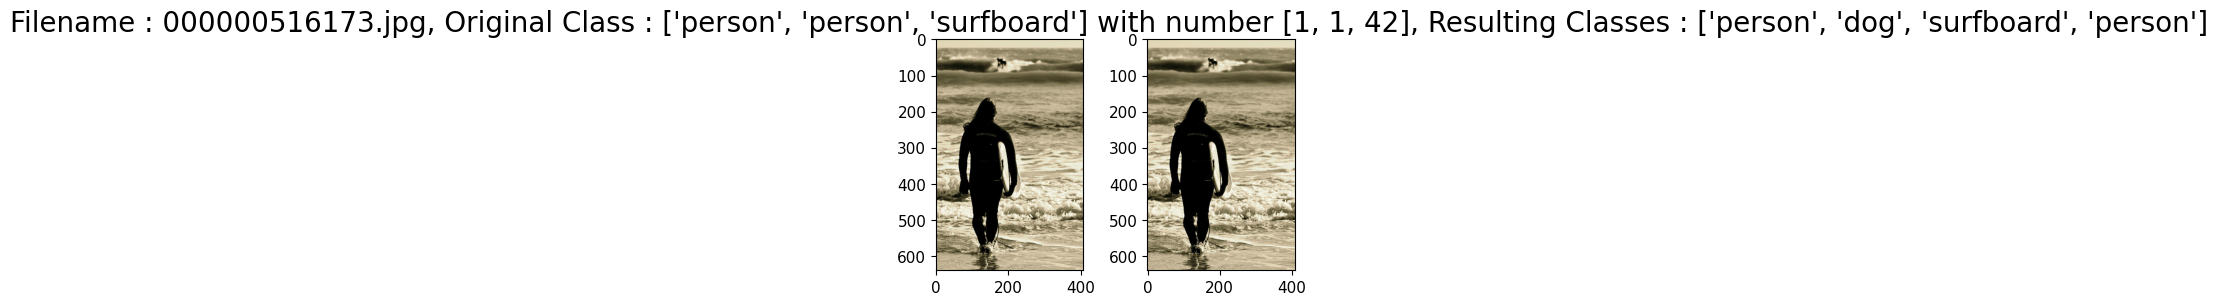

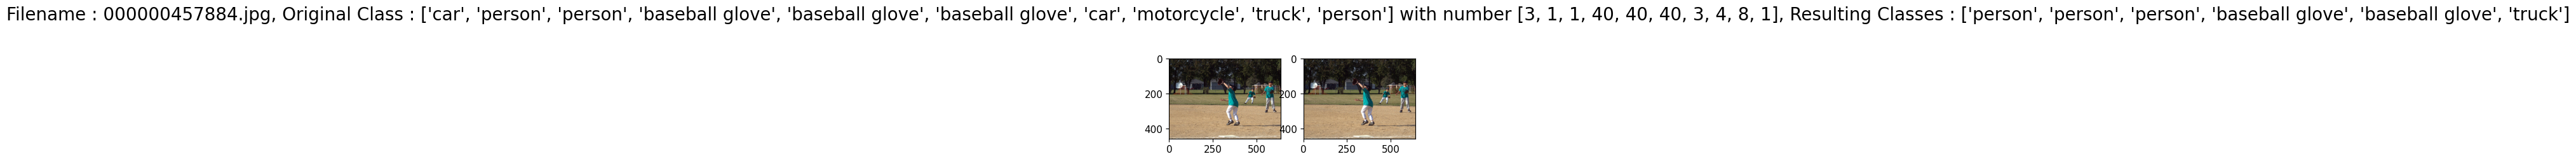

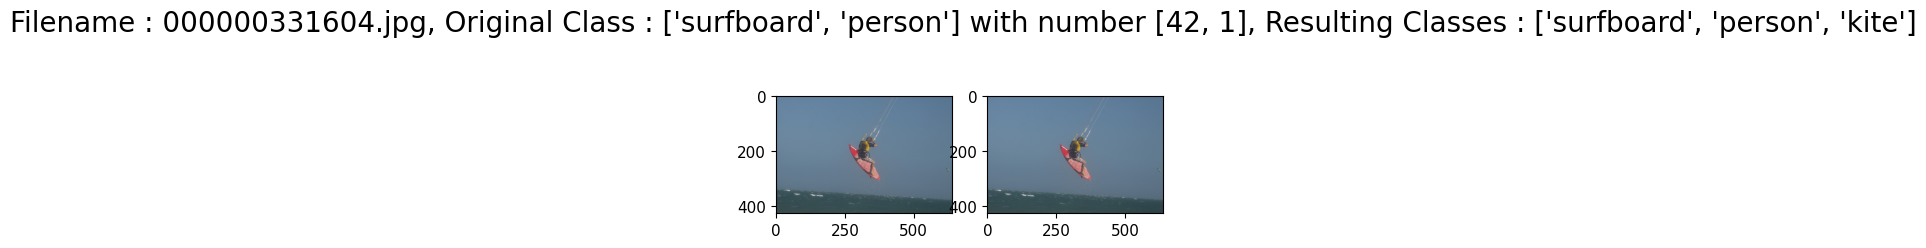

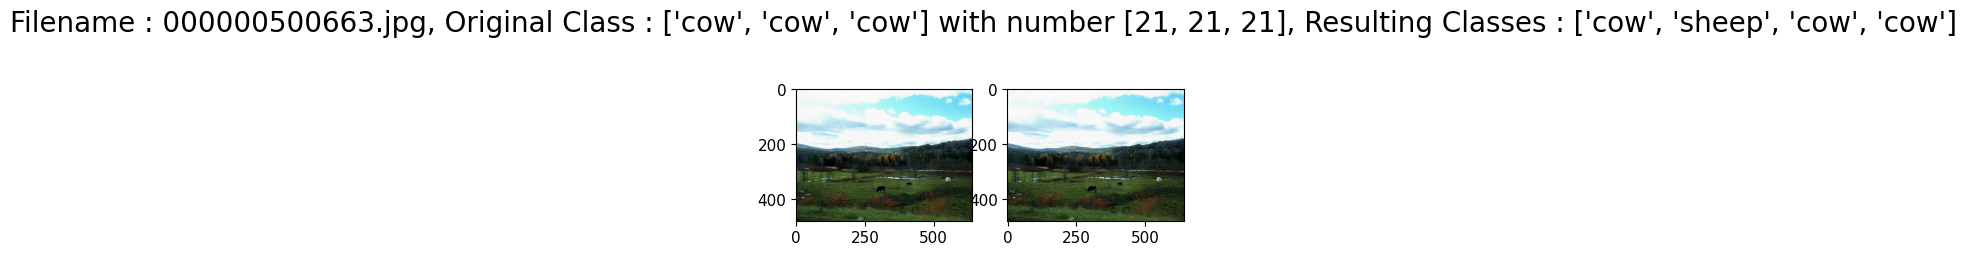

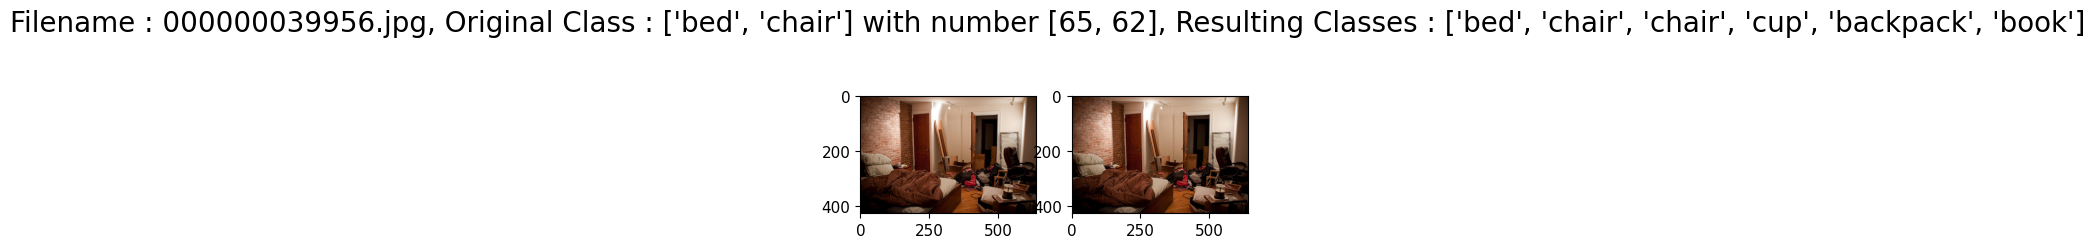

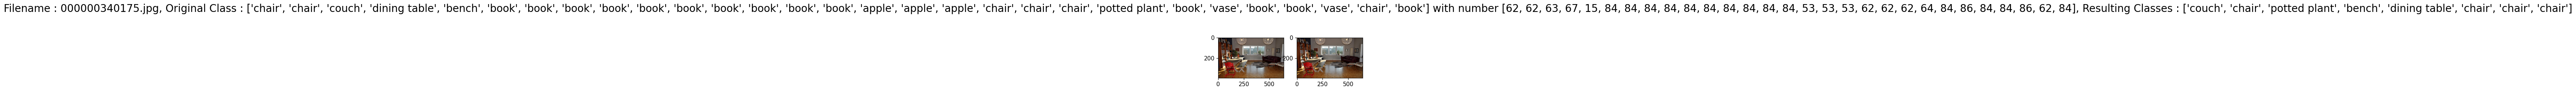

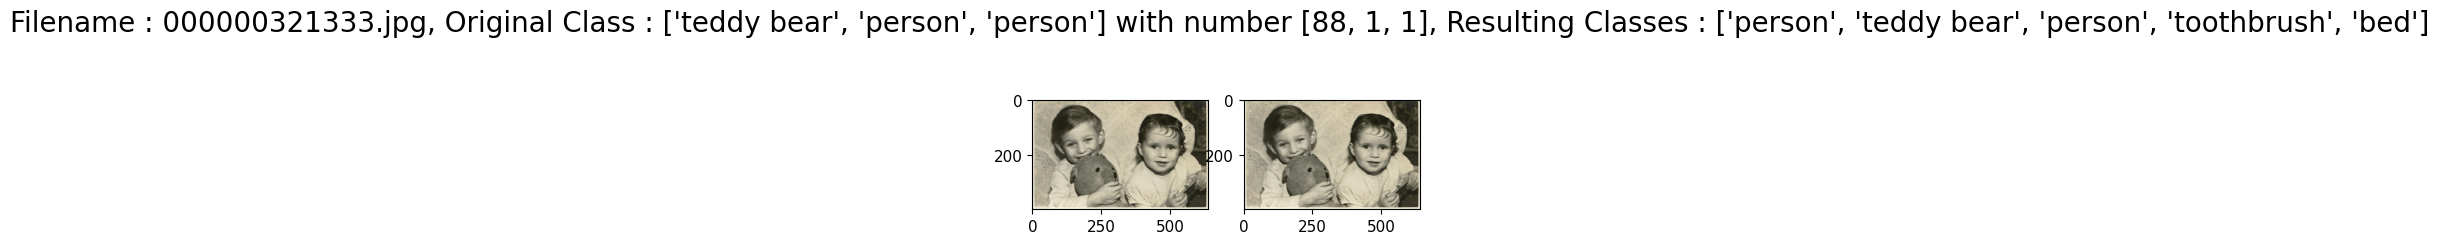

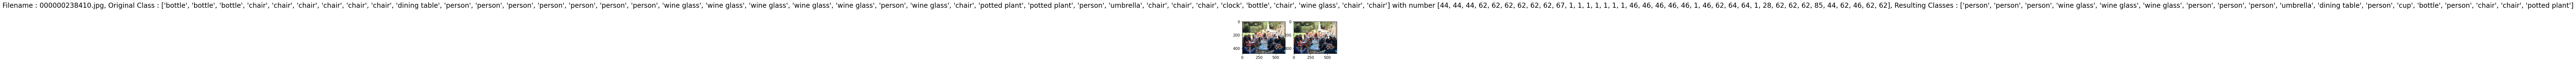

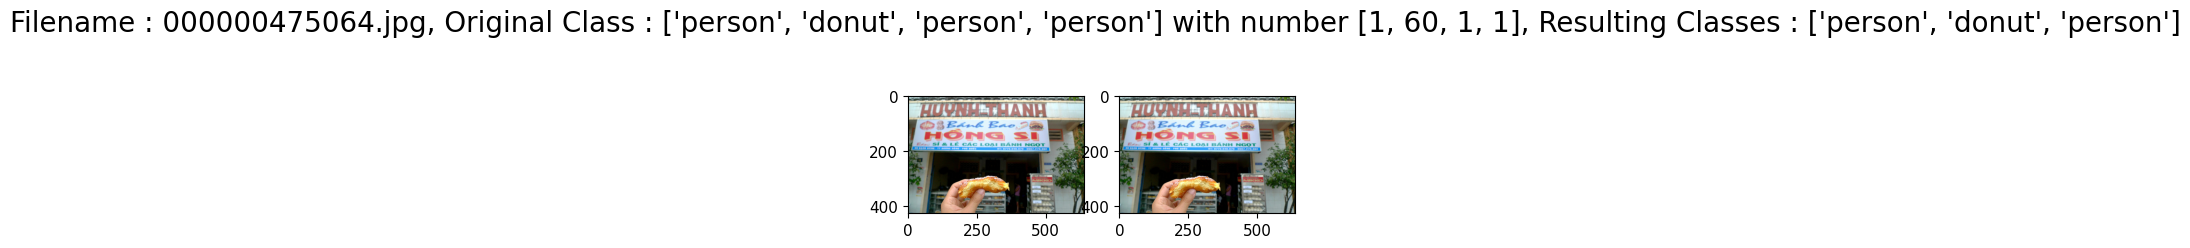

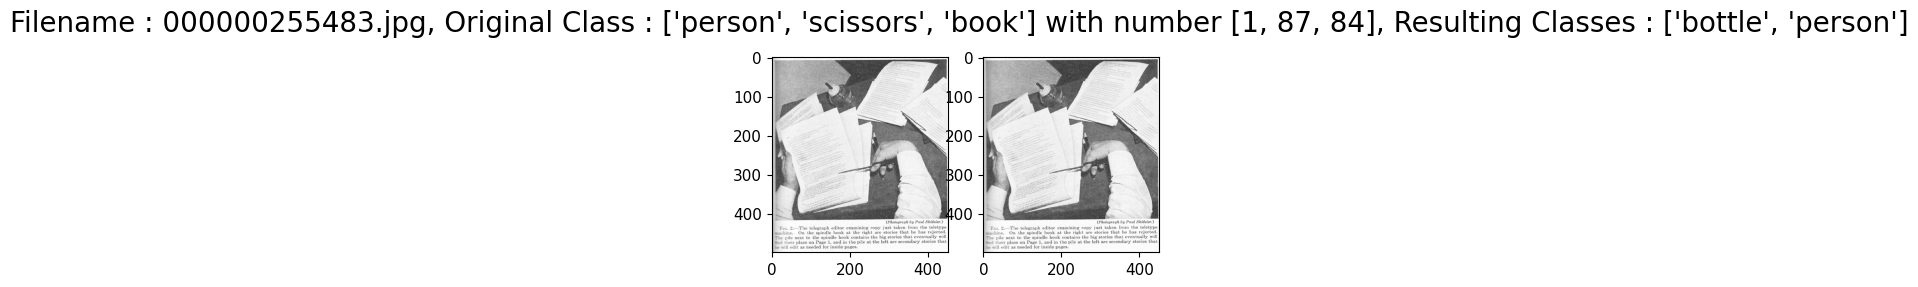

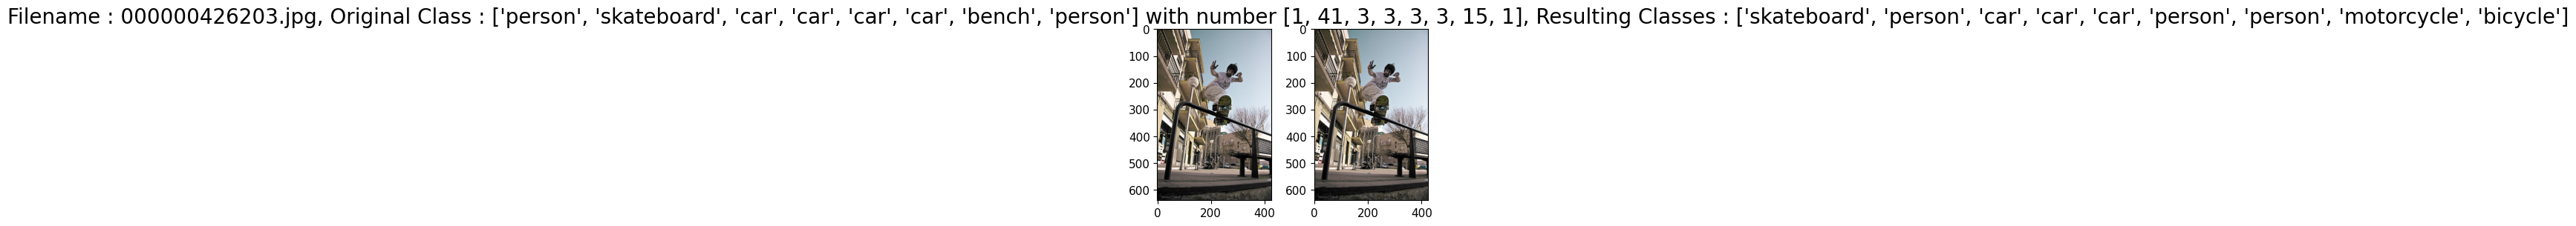

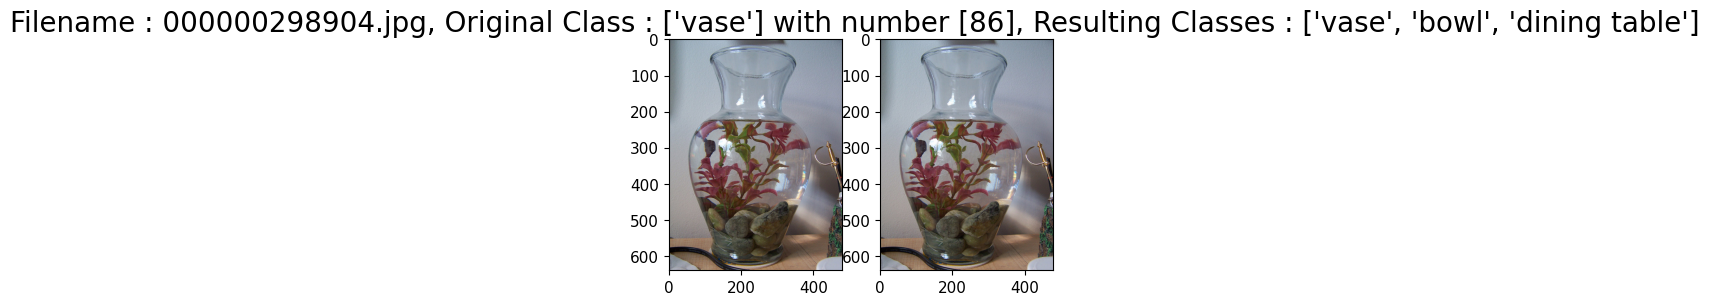

ACCURACY :  0.7994428969359332
RECALL :  0.6162361623616236
PRECISON :  0.8067632850241546
F_MESURE :  0.698744769874477


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np

# Number of the sample
nbr_images = 30
# initiating the data dict with class name their prediction
data = {key: {'origin':0, 'predict':0} for key in name_classes}
# initiating the True Positif (TP), True Negatif (TN), False Positif(FP) and False Negatif
TP = 0
TN = 0
FP = 0
FN = 0

# looping over the images
for i in os.listdir('/content/datasets/coco/images/val2017')[:nbr_images]:
    #reading the images one by one
    image = cv2.imread(f'/content/datasets/coco/images/val2017/{i}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #getting the image name
    name = os.path.splitext(i)[0]
    print("\nNAME : ", name)
    #if we want to use images without any transformations
    result_img = image
    # else uncomment result_img for using the transformations
    #result_img = transform(image=image)['image']
    idx = image_names.index(i)
    # getting the original classes of the image
    original_class = test_id_filename[i]["classes"]
    # getting the class number
    original_class_number = test_id_filename[i]["annotation"]
    # transposing the dimensions 0 and 2 of the tensor of result_img
    torch_img = torch.transpose(torch.Tensor(result_img), 0, 2)
    print("shape ? ", torch_img.shape)
    # inferencing the modal with result_img and storing the result in a list named results
    results = model(result_img).pandas().xyxy[0]['name'].tolist()
  
    print("Original class : ", original_class)
    # ploting a figure with the original images with the original classes 
    #and the result image with the result classes mentioned 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    fig.suptitle(f'Filename : {i}, Original Class : {original_class} with number {original_class_number}, Resulting Classes : {results}', fontsize=20)
    axes[0].imshow(image)
    axes[1].imshow(result_img)
    
    
    print("results : ", results)
    
    for item in set(original_class+results):
      #print("item", item)
      
      if item !='':
        # adding the counts of the original and the predicts for an optional future use for matrix of confusion
        # this is not implemented in this code
        data[item]['origin'] += original_class.count(item)
        data[item]['predict'] += results.count(item)
        # calculation of the TN, TP, FN and FP
        TP += min(original_class.count(item), results.count(item))
        TN += (len(original_class)-original_class.count(item)) - (len(results)-results.count(item))
        FP += max(0, results.count(item)-original_class.count(item))
        FN += original_class.count(item)-results.count(item) if (original_class.count(item)-results.count(item))>0 else 0

# creating the dataframe with the classes name, the count of what should have been predicted 
# and what actual was predicted for each class 
df = pd.DataFrame(data)
plt.show()

# calcultaing the metrics accuracy, recall, precision, f_mesure
accuracy =   (TP + TN) / (TP + TN + FP + FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f_mesure = 2*precision*recall/(precision+recall)

# printing the metrics
print("ACCURACY : ", accuracy)
print("RECALL : ", recall)
print("PRECISON : ", precision)
print("F_MESURE : ", f_mesure)
